Soft deadline: `30.03.2022 23:59`

Student: Nemat Allah Aloush

Group number : J41332c

ISU number : 336092

In case GitHub is not renderein the output cells, https://nbviewer.org/

In this homework you will understand the fine-tuning procedure and get acquainted with Huggingface Datasets library

In [1]:
# Mounting to google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [1]:
! pip install transformers

In [2]:
! pip install git+https://github.com/huggingface/datasets.git

  Cloning https://github.com/huggingface/datasets.git to c:\users\user\appdata\local\temp\pip-req-build-oiifhv47
  Resolved https://github.com/huggingface/datasets.git to commit bfb3d0916e95ae1d14412cbdbbc7d24cd91170c2


  Running command git clone -q https://github.com/huggingface/datasets.git 'C:\Users\User\AppData\Local\Temp\pip-req-build-oiifhv47'


For our goals we will use [Datasets](https://huggingface.co/docs/datasets/) library and take `yahoo_answers_topics` dataset - the task of this dataset is to divide documents on 10 topic categories. More detiled information can be found on the dataset [page](https://huggingface.co/datasets/viewer/).


In [3]:
from datasets import load_dataset

In [4]:
dataset = load_dataset('yahoo_answers_topics', download_mode="force_redownload") # the result is a dataset dictionary of train and test splits in this case

Dataset yahoo_answers_topics downloaded and prepared to C:\Users\User\.cache\huggingface\datasets\yahoo_answers_topics\yahoo_answers_topics\1.0.0\0edb353eefe79d9245d7bd7cac5ae6af19530439da520d6dde1c206ee38f4439. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 11.98it/s]


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'topic', 'question_title', 'question_content', 'best_answer'],
        num_rows: 1400000
    })
    test: Dataset({
        features: ['id', 'topic', 'question_title', 'question_content', 'best_answer'],
        num_rows: 60000
    })
})

In [ ]:
dataset['train'][0]

{'best_answer': 'Optical mice use an LED and a camera to rapidly capture images of the surface beneath the mouse.  The infomation from the camera is analyzed by a DSP (Digital Signal Processor) and used to detect imperfections in the underlying surface and determine motion. Some materials, such as glass, mirrors or other very shiny, uniform surfaces interfere with the ability of the DSP to accurately analyze the surface beneath the mouse.  \\nSince glass is transparent and very uniform, the mouse is unable to pick up enough imperfections in the underlying surface to determine motion.  Mirrored surfaces are also a problem, since they constantly reflect back the same image, causing the DSP not to recognize motion properly. When the system is unable to see surface changes associated with movement, the mouse will not work properly.',
 'id': 0,
 'question_content': 'or even on some surfaces?',
 'question_title': "why doesn't an optical mouse work on a glass table?",
 'topic': 4}

In [ ]:
dataset['train']

1400000

# Fine-tuning the model** (20 points)

In [5]:
from transformers import (ElectraTokenizer, ElectraForSequenceClassification,
                          get_scheduler, pipeline, ElectraForMaskedLM, ElectraModel,
                          Trainer,TrainingArguments, InputFeatures) 

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from datasets import load_metric

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Fine-tuning procedure on the end task consists of adding additional layers on the top of the pre-trained model. The resulting model can be tuned fully (passing gradients through the all model) or partially.

**Task**: 
- load tokenizer and model
- look at the predictions of the model as-is before any fine-tuning


```
- Why don't you ask [MASK]?
- What is [MASK]
- Let's talk about [MASK] physics
```

- convert `best_answer` to the input tokens (supporting function for dataset is provided below) 

```
def tokenize_function(examples):
    return tokenizer(examples["best_answer"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
```

- define optimizer, sheduler (optional)
- fine-tune the model (write the training loop), plot the loss changes and measure results in terms of weighted F1 score
- get the masked word prediction (sample sentences above) on the fine-tuned model, why the results as they are and what should be done in order to change that (write down your answer)
- Tune the training hyperparameters (and write down your results).

**Tips**:
- The easiest way to get predictions is to use transformers `pipeline` function 
- Do not forget to set `num_labels` parameter, when initializing the model
- To convert data to batches use `DataLoader`
- Even the `small` version of Electra can be long to train, so you can take data sample (>= 5000 and set seed for reproducibility)
- You may want to try freezing (do not update the pretrained model weights) all the layers exept the ones for classification, in that case use:


```
for param in model.electra.parameters():
      param.requires_grad = False
```


### load tokenizer and model
Do not forget to set num_labels parameter, when initializing the model

In [7]:
MODEL_NAME = "google/electra-small-generator"
TOKENIZER_NAME = "google/electra-small-generator"

In [8]:
tokenizer = ElectraTokenizer.from_pretrained(TOKENIZER_NAME)
model = ElectraForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=10)


Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForSequenceClassification: ['generator_predictions.LayerNorm.bias', 'generator_lm_head.weight', 'generator_predictions.LayerNorm.weight', 'generator_predictions.dense.bias', 'generator_lm_head.bias', 'generator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-generator and are newly initializ

### look at the predictions of the model as-is before any fine-tuning
The easiest way to get predictions is to use transformers pipeline function

In [8]:
predictor = pipeline("fill-mask", model=MODEL_NAME)

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
sen_1 = "Why don't you ask [MASK]?"
predictor(sen_1)

[{'score': 0.5342992544174194,
  'sequence': "why don't you ask me?",
  'token': 2033,
  'token_str': 'me'},
 {'score': 0.08196018636226654,
  'sequence': "why don't you ask questions?",
  'token': 3980,
  'token_str': 'questions'},
 {'score': 0.04395333677530289,
  'sequence': "why don't you ask them?",
  'token': 2068,
  'token_str': 'them'},
 {'score': 0.04017288610339165,
  'sequence': "why don't you ask why?",
  'token': 2339,
  'token_str': 'why'},
 {'score': 0.030024440959095955,
  'sequence': "why don't you ask yourself?",
  'token': 4426,
  'token_str': 'yourself'}]

In [ ]:
sen_2 = "What is [MASK]?"
predictor(sen_2)

[{'score': 0.4963124096393585,
  'sequence': 'what is it?',
  'token': 2009,
  'token_str': 'it'},
 {'score': 0.2050585150718689,
  'sequence': 'what is this?',
  'token': 2023,
  'token_str': 'this'},
 {'score': 0.12763532996177673,
  'sequence': 'what is that?',
  'token': 2008,
  'token_str': 'that'},
 {'score': 0.015324895270168781,
  'sequence': 'what is wrong?',
  'token': 3308,
  'token_str': 'wrong'},
 {'score': 0.01502312533557415,
  'sequence': 'what is what?',
  'token': 2054,
  'token_str': 'what'}]

In [ ]:
sen_3 =  "Let's talk about [MASK] physics"
predictor(sen_3)

[{'score': 0.24027501046657562,
  'sequence': "let's talk about quantum physics",
  'token': 8559,
  'token_str': 'quantum'},
 {'score': 0.21258601546287537,
  'sequence': "let's talk about theoretical physics",
  'token': 9373,
  'token_str': 'theoretical'},
 {'score': 0.056394025683403015,
  'sequence': "let's talk about particle physics",
  'token': 10811,
  'token_str': 'particle'},
 {'score': 0.0332079641520977,
  'sequence': "let's talk about real physics",
  'token': 2613,
  'token_str': 'real'},
 {'score': 0.022627945989370346,
  'sequence': "let's talk about mathematical physics",
  'token': 8045,
  'token_str': 'mathematical'}]

### Convert best_answer to the input tokens (supporting function for dataset is provided below)

In [9]:
def tokenize_function(examples):
    return tokenizer(examples, padding="max_length", truncation=True)

In [10]:
samples_number=5000

In [11]:
tokenized_train_datasets = tokenize_function(dataset["train"]["best_answer"][:samples_number])#.map(tokenize_function, batched=True)

In [12]:
tokenized_test_datasets = tokenize_function(dataset["test"]["best_answer"][:samples_number])#.map(tokenize_function, batched=True)

In [13]:
train_datasets_topics= dataset["train"]["topic"][:samples_number]

In [14]:
test_datasets_topics= dataset["test"]["topic"][:samples_number]

### define optimizer, sheduler (optional)
In order to perform the training, I am using Trainer() and by default it uses optimizer (an instance of AdamW on your model) and a scheduler (given by get_linear_schedule_with_warmup()) 

### fine-tune the model (write the training loop), plot the loss changes and measure results in terms of weighted F1 score

In [15]:
class dataset_for_trainer (Dataset): #must implement __len__ and __getitem__
    def __init__(self, tokenized_data,topics,length):
      self.tokenized_data=tokenized_data
      self.labels=topics
      self.length=length

    def __len__(self):
      return (self.length)

    def __getitem__(self, id):
      return InputFeatures(
            input_ids=self.tokenized_data['input_ids'][id],
            token_type_ids=self.tokenized_data['token_type_ids'][id],
            attention_mask=self.tokenized_data['attention_mask'][id],
            label=self.labels[id])



In [16]:
training= dataset_for_trainer(tokenized_train_datasets,train_datasets_topics,samples_number)

In [17]:
evaluating=dataset_for_trainer(tokenized_test_datasets,test_datasets_topics,samples_number)

In [18]:
np.random.seed(7)
torch.manual_seed(7)

training_args = TrainingArguments(
    output_dir="/content/drive/My Drive/output",
    overwrite_output_dir=True,
    evaluation_strategy="steps",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    do_train=True,
    do_eval=True,)

In [19]:
metric = load_metric('f1')

def compute_metrics(pred):
    predictions, label_ids = pred
    preds = np.argmax(predictions, axis=1)
    return metric.compute(
        predictions=preds, references=label_ids, average="weighted")
   

In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=training,
    eval_dataset=evaluating,
    compute_metrics=compute_metrics
    )

In [ ]:
train_info = trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5000
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3125


Step,Training Loss,Validation Loss,F1
500,0.987100,1.467952,0.538092
1000,0.902300,1.543128,0.539431
1500,0.803900,1.619953,0.522479
2000,0.659900,1.721062,0.532423
2500,0.556900,1.727321,0.534846
3000,0.453800,1.785547,0.538925


***** Running Evaluation *****
  Num examples = 5000
  Batch size = 8
Saving model checkpoint to /content/drive/My Drive/output/checkpoint-500
Configuration saved in /content/drive/My Drive/output/checkpoint-500/config.json
Model weights saved in /content/drive/My Drive/output/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 8
Saving model checkpoint to /content/drive/My Drive/output/checkpoint-1000
Configuration saved in /content/drive/My Drive/output/checkpoint-1000/config.json
Model weights saved in /content/drive/My Drive/output/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 8
Saving model checkpoint to /content/drive/My Drive/output/checkpoint-1500
Configuration saved in /content/drive/My Drive/output/checkpoint-1500/config.json
Model weights saved in /content/drive/My Drive/output/checkpoint-1500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5000
  Batch 

In [ ]:
train_info

TrainOutput(global_step=3125, training_loss=0.7166390466308594, metrics={'train_runtime': 1600.5695, 'train_samples_per_second': 15.619, 'train_steps_per_second': 1.952, 'total_flos': 735648921600000.0, 'train_loss': 0.7166390466308594, 'epoch': 5.0})

Text(0, 0.5, 'Training Loss')

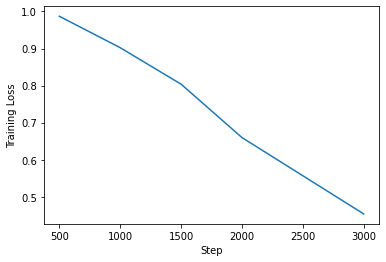

In [ ]:
steps=[500,1000 ,1500 ,2000 ,2500 ,3000 ]
loss= [0.987100,0.902300 , 0.803900,0.659900 , 0.556900, 0.453800 ]
plt.plot(steps, loss)
plt.xlabel("Step")
plt.ylabel("Training Loss")

Text(0, 0.5, 'Validation Loss')

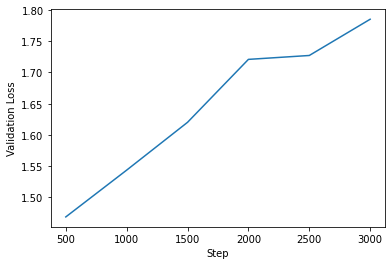

In [ ]:
steps=[500,1000 ,1500 ,2000 ,2500 ,3000 ]
loss= [1.467952,1.543128 , 1.619953,1.721062 , 1.727321, 1.785547 ]
plt.plot(steps, loss)
plt.xlabel("Step")
plt.ylabel("Validation Loss")

In [ ]:
evaluation_result = trainer.evaluate()
evaluation_result

***** Running Evaluation *****
  Num examples = 5000
  Batch size = 8


{'epoch': 5.0,
 'eval_f1': 0.5385933649075498,
 'eval_loss': 1.7877246141433716,
 'eval_runtime': 75.1251,
 'eval_samples_per_second': 66.556,
 'eval_steps_per_second': 8.319}

### get the masked word prediction (sample sentences above) on the fine-tuned model, why the results as they are and what should be done in order to change that (write down your answer)

In [ ]:
model.save_pretrained("/content/drive/MyDrive/Untitled Folder/trained")

Configuration saved in /content/drive/MyDrive/Untitled Folder/trained/config.json
Model weights saved in /content/drive/MyDrive/Untitled Folder/trained/pytorch_model.bin


In [ ]:
trained_model = ElectraForMaskedLM.from_pretrained("/content/drive/MyDrive/Untitled Folder/trained")

loading configuration file /content/drive/MyDrive/Untitled Folder/trained/config.json
Model config ElectraConfig {
  "_name_or_path": "google/electra-small-generator",
  "architectures": [
    "ElectraForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9"
  },
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "

In [ ]:
predictor_trained = pipeline("fill-mask", model=trained_model, tokenizer=tokenizer)

In [ ]:
predictor_trained(sen_1)

[{'score': 0.0003825551248155534,
  'sequence': "why don't you asklizer?",
  'token': 28863,
  'token_str': '# # l i z e r'},
 {'score': 0.00036645226646214724,
  'sequence': "why don't you ask manitoba?",
  'token': 10512,
  'token_str': 'm a n i t o b a'},
 {'score': 0.0003258672368247062,
  'sequence': "why don't you askhale?",
  'token': 15238,
  'token_str': '# # h a l e'},
 {'score': 0.00030835444340482354,
  'sequence': "why don't you ask prime?",
  'token': 3539,
  'token_str': 'p r i m e'},
 {'score': 0.0003023090248461813,
  'sequence': "why don't you askerland?",
  'token': 22492,
  'token_str': '# # e r l a n d'}]

In [ ]:
predictor_trained(sen_2)

[{'score': 0.0003889001382049173,
  'sequence': 'what islizer?',
  'token': 28863,
  'token_str': '# # l i z e r'},
 {'score': 0.0003770088078454137,
  'sequence': 'what iswest?',
  'token': 19650,
  'token_str': '# # w e s t'},
 {'score': 0.0003740653919521719,
  'sequence': 'what islington?',
  'token': 18722,
  'token_str': '# # l i n g t o n'},
 {'score': 0.0003371702623553574,
  'sequence': 'what is chihuahua?',
  'token': 28480,
  'token_str': 'c h i h u a h u a'},
 {'score': 0.00031758195837028325,
  'sequence': 'what isguide?',
  'token': 28582,
  'token_str': '# # g u i d e'}]

In [ ]:
predictor_trained(sen_3)

[{'score': 0.00028710137121379375,
  'sequence': "let's talk aboutnded physics",
  'token': 25848,
  'token_str': '# # n d e d'},
 {'score': 0.0002739493502303958,
  'sequence': "let's talk about bhp physics",
  'token': 22245,
  'token_str': 'b h p'},
 {'score': 0.0002729956468101591,
  'sequence': "let's talk aboutcian physics",
  'token': 14483,
  'token_str': '# # c i a n'},
 {'score': 0.00026779426843859255,
  'sequence': "let's talk about cerro physics",
  'token': 25498,
  'token_str': 'c e r r o'},
 {'score': 0.00026544061256572604,
  'sequence': "let's talk about frigate physics",
  'token': 15437,
  'token_str': 'f r i g a t e'}]

### Tune the training hyperparameters (and write down your results).

In [21]:
device = 'cuda'
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
#tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
#dataset = load_dataset('glue', 'mrpc')
#metric = load_metric('glue', 'mrpc')


#encoded_dataset = dataset.map(encode, batched=True)
# Won't be necessary when this PR is merged with master since the Trainer will do it automatically
#encoded_dataset.set_format(columns=['attention_mask', 'input_ids', 'token_type_ids', 'label'])

def model_init():
    return ElectraForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=10, return_dict=True)

#def compute_metrics(eval_pred):
#    predictions, labels = eval_pred
#    predictions = predictions.argmax(axis=-1)
#    return metric.compute(predictions=predictions, references=labels)

# Evaluate during training and a bit more often than the default to be able to prune bad trials early.
# Disabling tqdm is a matter of preference.
#training_args = TrainingArguments("test", evaluate_during_training=True, eval_steps=500, disable_tqdm=True)
trainer = Trainer(
    args=training_args,
    #data_collator=DataCollatorWithPadding(tokenizer),
    train_dataset=training, #encoded_dataset["train"], 
    eval_dataset=evaluating, #encoded_dataset["validation"], 
    model_init=model_init,
    compute_metrics=compute_metrics,
)

# Defaut objective is the sum of all metrics when metrics are provided, so we have to maximize it.
trainer.hyperparameter_search(direction="maximize")

In [ ]:
trainer.evaluate()

f1 before tuning 0.54 _____ f1 after tuning 0.58 _____ difference 8%